# APM466 Assignment 1

You will need `bond_data.csv` in order for this file to run. You can generate this file by running every cell in `data_download.ipynb`.

In [6]:
import numpy as np
import pandas as pd
from collections import namedtuple
from datetime import date, datetime

BondTimeSeries = namedtuple("BondTimeSeries", ["name", "isin", "coupon", "date_issue", "date_maturity", "time_series"])

target_dates = pd.date_range("2025-01-06", periods=10, freq="B").strftime("%Y-%m-%d %H:%M").tolist()
target_dates

['2025-01-06 00:00',
 '2025-01-07 00:00',
 '2025-01-08 00:00',
 '2025-01-09 00:00',
 '2025-01-10 00:00',
 '2025-01-13 00:00',
 '2025-01-14 00:00',
 '2025-01-15 00:00',
 '2025-01-16 00:00',
 '2025-01-17 00:00']

In [7]:
bonds = []

# Read the bond data from CSV file
bond_data = pd.read_csv('bond_data.csv')
for index, row in bond_data.iterrows():
    name = row["Name"]
    time_series = {key: row[key] for key in target_dates}
    bonds.append(BondTimeSeries(
        name=row["Name"],
        isin=row["ISIN"],
        coupon=row["Coupon"],
        date_issue=datetime.strptime(row["Issue Date"], "%Y-%m-%d").date(),
        date_maturity=datetime.strptime(row["Maturity Date"], "%Y-%m-%d").date(),
        time_series=time_series,
    ))

bonds

[BondTimeSeries(name='CAN 1.25 Mar 25', isin='CA135087K528', coupon=0.0125, date_issue=datetime.date(2019, 10, 11), date_maturity=datetime.date(2025, 3, 1), time_series={'2025-01-06 00:00': 99.73, '2025-01-07 00:00': 99.73, '2025-01-08 00:00': 99.74, '2025-01-09 00:00': 99.73, '2025-01-10 00:00': 99.74, '2025-01-13 00:00': 99.73, '2025-01-14 00:00': 99.73, '2025-01-15 00:00': 99.77, '2025-01-16 00:00': 99.78, '2025-01-17 00:00': 99.8}),
 BondTimeSeries(name='CAN 0.50 Sep 25', isin='CA135087K940', coupon=0.005, date_issue=datetime.date(2020, 4, 3), date_maturity=datetime.date(2025, 9, 1), time_series={'2025-01-06 00:00': 98.4, '2025-01-07 00:00': 98.41, '2025-01-08 00:00': 98.4, '2025-01-09 00:00': 98.42, '2025-01-10 00:00': 98.37, '2025-01-13 00:00': 98.36, '2025-01-14 00:00': 98.36, '2025-01-15 00:00': 98.4, '2025-01-16 00:00': 98.47, '2025-01-17 00:00': 98.5}),
 BondTimeSeries(name='CAN 4.50 Feb 26', isin='CA135087R226', coupon=0.045, date_issue=datetime.date(2023, 11, 1), date_matur

In [8]:
BondObservation = namedtuple("BondObservation", ["name", "coupon", "date_issue", "date_maturity", "date_observation", "price"])

def get_observations_for_date(d: date) -> list[BondObservation]:
    observations = []
    for bond in bonds:
        obs = BondObservation(
            name=bond.name,
            coupon=bond.coupon,
            date_issue=bond.date_issue,
            date_maturity=bond.date_maturity,
            date_observation=d,
            price=bond.time_series[d.strftime("%Y-%m-%d 00:00")]
        )
        observations.append(obs)
    return observations

### Calculate each bond's ytm

In [29]:
def year_fraction(start_date: date, end_date: date) -> float:
    return (end_date - start_date).days / 365.0

In [67]:
MaturityYield = namedtuple("MaturityYield", ["years_to_maturity", "yield_to_maturity"])

def get_ytms_for_date(target_datetime: str) -> list[MaturityYield]:
    ytms = []
    for bond in bonds:
        target_date = datetime.strptime(target_datetime, "%Y-%m-%d 00:00").date()
        price = bond.time_series[target_datetime]
        years_to_maturity = year_fraction(target_date, bond.date_maturity)
        ytm = (bond.coupon*100 + (100 - price) / years_to_maturity) \
              / ((100 + price) / 2)
        ytms.append(MaturityYield(years_to_maturity, ytm))
    return ytms

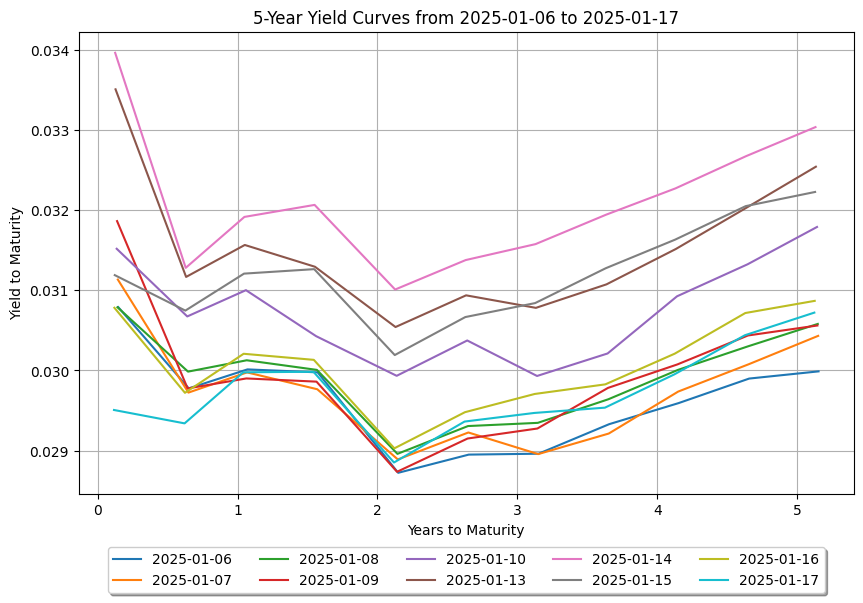

In [68]:
import matplotlib.pyplot as plt

curves = [get_ytms_for_date(d) for d in target_dates]

plt.figure(figsize=(10, 6))

for curve, date in zip(curves, target_dates):
    x = [ytm.years_to_maturity for ytm in curve]
    y = [ytm.yield_to_maturity for ytm in curve]
    plt.plot(x, y, label=date[:-6])

plt.xlabel('Years to Maturity')
plt.ylabel('Yield to Maturity')
plt.title('5-Year Yield Curves from 2025-01-06 to 2025-01-17')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          ncol=5, fancybox=True, shadow=True)
plt.grid(True)
plt.show()

### Bootstrap the spot curve

In [3]:
!pip install python-dateutil
from dateutil.relativedelta import relativedelta

In [26]:
SpotRate = namedtuple("SpotRate", ["date", "rate"])

def get_closest_spot_rate(spot_rates: list[SpotRate], target_date: date) -> SpotRate:
    closest_date = None
    closest_rate = None
    for spot_rate in spot_rates:
        if closest_date is None or abs(year_fraction(spot_rate.date, target_date)) < abs(year_fraction(closest_date, target_date)):
            closest_date = spot_rate.date
            closest_rate = spot_rate.rate
    return SpotRate(date=closest_date, rate=closest_rate)

def bootstrap_yield_curve(bonds: list[BondObservation], valuation_date: date) -> list[float]:
    bonds = sorted(bonds, key=lambda x: x.date_maturity)  # Sort by maturity date
    spot_rates = []
    
    for idx, bond in enumerate(bonds):
        assert bond.date_issue < valuation_date, f"Bond [{bond.name}] will be issued in the future"
        cfs_to_maturity = []
        cf_dates = []
        test_date = bond.date_maturity - relativedelta(months=60)
        while test_date <= bond.date_maturity:
            if valuation_date < test_date < bond.date_maturity:
                cfs_to_maturity.append(100 * (bond.coupon / 2))
                cf_dates.append(test_date)
            if test_date == bond.date_maturity:
                cfs_to_maturity.append(100 * (bond.coupon / 2 + 1))
                cf_dates.append(test_date)
            test_date += relativedelta(months=6)
        assert len(cfs_to_maturity) > 0, f"No cash flows for bond [{bond.name}]"
        assert len(cfs_to_maturity) == len(cf_dates), f"Number of cash flows and dates do not match for bond [{bond.name}]"
        assert len(cfs_to_maturity) == idx + 1
        assert cf_dates[-1] == bond.date_maturity, f"Last cash flow date does not match maturity date for bond [{bond.name}]"
        spot_rate = None
        years_to_maturity = year_fraction(valuation_date, bond.date_maturity)
        if idx == 0:
            spot_rate = ((cfs_to_maturity[0] / bond.price) ** (1 / years_to_maturity)) - 1
        else:
            pv_all_cf_but_last = sum(
                cf / ((1 + get_closest_spot_rate(spot_rates, cf_date).rate) ** year_fraction(valuation_date, cf_date)) \
                for cf, cf_date in zip(cfs_to_maturity[:-1], cf_dates[:-1])
            )
            spot_rate = ((cfs_to_maturity[-1] / (bond.price - pv_all_cf_but_last)) ** (1 / years_to_maturity)) - 1
        spot_rates.append(SpotRate(date=bond.date_maturity, rate=spot_rate))

    return spot_rates

In [27]:
valuation_date = date(2025, 1, 6)
bonds_data = get_observations_for_date(valuation_date)

spot_rates = bootstrap_yield_curve(bonds_data, valuation_date)
__import__('pprint').pprint(spot_rates)

[SpotRate(date=datetime.date(2025, 3, 1), rate=0.062249238385056804),
 SpotRate(date=datetime.date(2025, 9, 1), rate=0.032963727612006055),
 SpotRate(date=datetime.date(2026, 2, 1), rate=0.04911629435348486),
 SpotRate(date=datetime.date(2026, 8, 3), rate=0.04146597050775913),
 SpotRate(date=datetime.date(2027, 3, 1), rate=0.03113002051745961),
 SpotRate(date=datetime.date(2027, 9, 1), rate=0.03285281928329331),
 SpotRate(date=datetime.date(2028, 3, 1), rate=0.033076590476629475),
 SpotRate(date=datetime.date(2028, 9, 1), rate=0.03266418273949134),
 SpotRate(date=datetime.date(2029, 3, 1), rate=0.03318269962835396),
 SpotRate(date=datetime.date(2029, 9, 1), rate=0.03276484777963162),
 SpotRate(date=datetime.date(2030, 3, 1), rate=0.03217698236947819)]


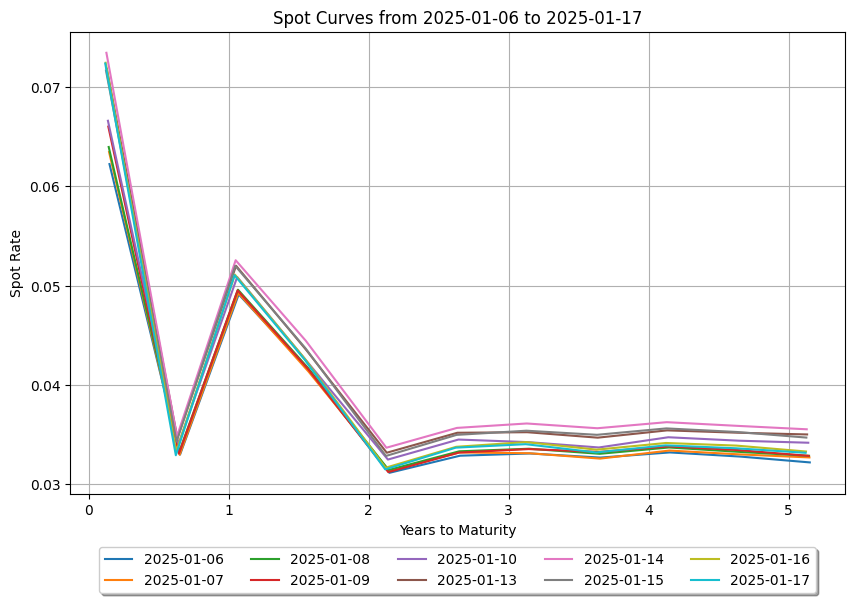

In [66]:
plt.figure(figsize=(10, 6))

for date in target_dates:
    bonds_data = get_observations_for_date(datetime.strptime(date, "%Y-%m-%d %H:%M").date())
    spot_rates = bootstrap_yield_curve(bonds_data, datetime.strptime(date, "%Y-%m-%d %H:%M").date())
    x = [year_fraction(datetime.strptime(date, "%Y-%m-%d %H:%M").date(), spot_rate.date) for spot_rate in spot_rates]
    y = [spot_rate.rate for spot_rate in spot_rates]
    plt.plot(x, y, label=date[:-6])

plt.xlabel('Years to Maturity')
plt.ylabel('Spot Rate')
plt.title('Spot Curves from 2025-01-06 to 2025-01-17')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
           ncol=5, fancybox=True, shadow=True)
plt.grid(True)
plt.show()